## Import librerie

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import math
import matplotlib.pyplot as plt

## Hybrid Quantum-Classical Neural Network

In [ ]:
"""
Implementazione di un Hybrid Quantum Diffusion Model.
- Forward process: Autoencoder classico
- Backward process: Circuito quantistico parametrizzato (PQC)

Basato sull'architettura reverse-bottleneck descritta nel paper.
Include correzioni per le dimensioni dei parametri e configurazioni 
basate sui risultati di simulazione presentati nel paper.
"""

# Definizione dei parametri del modello in base ai risultati di simulazione del paper
latent_qubits = 3    # 3 qubit per il modello latente
m_ancilla = 1        # Numero di qubit ancillari
label_qubits = 4     # 4 qubit per codificare le 10 classi MNIST

# Profondità circuito in base al paper
latent_n_layers = 50 // 3  # 50 layer totali distribuiti su 3 blocchi

# Parametri diffusione
timesteps = 15     # Numero ridotto di passi temporali come indicato nel paper
beta_min = 1e-4    # Minimo valore di beta per la schedule
beta_max = 0.02    # Massimo valore di beta per la schedule
latent_dim = 2**latent_qubits  # Dimensione per il modello latente

# Definizione della schedule del forward process
def get_beta_schedule(timesteps, beta_min, beta_max):
    """Crea la schedule dei beta per il processo di diffusione."""
    return np.linspace(beta_min, beta_max, timesteps)

# Calcolo degli alpha dal beta schedule
def compute_alpha(beta_schedule):
    """Calcola gli alpha e gli alpha cumulativi."""
    alpha = 1 - beta_schedule
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod

beta_schedule = get_beta_schedule(timesteps, beta_min, beta_max)
alpha, alpha_cumprod = compute_alpha(beta_schedule)

# PARTE 1: COMPONENTI DEL FORWARD PROCESS CLASSICO (AUTOENCODER)

class AutoencoderForward(nn.Module):
    """
    Autoencoder classico per il forward process.
    Implementa l'aggiunta di rumore gaussiano complesso ai dati.
    """
    def __init__(self, feature_dim, timesteps, alpha_cumprod):
        super(AutoencoderForward, self).__init__()
        self.feature_dim = feature_dim
        self.timesteps = timesteps
        self.alpha_cumprod = alpha_cumprod
    
    def forward_step(self, x, t):
        """
        Esegue un singolo passo del forward process aggiungendo rumore complesso.
        
        Args:
            x: Dati di input
            t: Timestep corrente
            
        Returns:
            x_t: Dati rumorosi al timestep t
            noise: Rumore complesso aggiunto
        """
        # Ottieni alpha per questo timestep
        a_t = self.alpha_cumprod[t]
        
        # Genera rumore complesso
        noise_real = torch.randn_like(x)
        noise_imag = torch.randn_like(x)
        noise = noise_real + 1j * noise_imag
        
        # Applica il rumore secondo l'equazione del paper
        x_t = torch.sqrt(torch.tensor(a_t)) * x + torch.sqrt(torch.tensor(1 - a_t)) * noise
        
        return x_t, noise
    
    def forward(self, x_0):
        """
        Esegue il processo completo di diffusione forward.
        
        Args:
            x_0: Dati originali
            
        Returns:
            x_t: Lista di dati diffusi per ogni timestep
        """
        x_t_sequence = []
        x_t = x_0
        
        # Applica sequenzialmente i passi di diffusione
        for t in range(self.timesteps):
            x_t, _ = self.forward_step(x_t, t)
            x_t_sequence.append(x_t)
        
        return x_t_sequence

# PARTE 2: COMPONENTI DEL BACKWARD PROCESS QUANTISTICO (PQC)

# Definizione del blocco unitario parametrizzato
def unitary_block(params, wires, n_layers):
    """
    Implementa un blocco unitario parametrizzato con layer di rotazione e entanglement.
    
    Args:
        params: Parametri del blocco
        wires: Qubit su cui applicare il blocco
        n_layers: Numero di layer nel blocco
    """
    n_wires = len(wires)
    
    # Layer di rotazioni singolo-qubit
    for i, wire in enumerate(wires):
        qml.RX(params[0, i], wires=wire)
        qml.RY(params[1, i], wires=wire)
        qml.RZ(params[2, i], wires=wire)
    
    # Layer di entanglement
    for layer in range(n_layers):
        # Entanglement con CNOT
        for i in range(n_wires-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
        qml.CNOT(wires=[wires[n_wires-1], wires[0]])  # Circular entanglement
        
        # Rotazioni parametrizzate
        for i, wire in enumerate(wires):
            qml.RX(params[3+layer*3, i], wires=wire)
            qml.RY(params[4+layer*3, i], wires=wire)
            qml.RZ(params[5+layer*3, i], wires=wire)

# Definizione dell'encoding dei dati classici in stati quantistici (amplitude encoding)
def amplitude_encode(x, wires):
    """
    Implementa l'amplitude encoding di un vettore classico in uno stato quantistico.
    
    Args:
        x: Vettore di dati classici (può essere complesso)
        wires: Qubit su cui codificare l'informazione
    """
    # Normalizzazione dell'ampiezza
    x_norm = x / np.sqrt(np.sum(np.abs(x)**2))
    qml.AmplitudeEmbedding(x_norm, wires=wires, normalize=True)

# PARTE 3: MODELLO COMPLETO QUANTUM DIFFUSION

# Creazione del dispositivo quantistico simulato 
def create_device(n_qubits, m_ancilla, extra_qubits=0):
    """
    Crea un dispositivo quantistico con il numero corretto di qubit.
    Utilizza default.mixed che supporta meglio le misurazioni intermedie.
    
    Args:
        n_qubits: Numero di qubit per i dati
        m_ancilla: Numero di qubit ancillari
        extra_qubits: Qubit aggiuntivi (per etichette, ecc.)
        
    Returns:
        Dispositivo quantistico PennyLane
    """
    total_qubits = n_qubits + m_ancilla + extra_qubits
    return qml.device('default.mixed', wires=total_qubits)

# Definizione del circuito quantistico parametrizzato per il reverse-bottleneck
def create_reverse_bottleneck_pqc(dev, n_qubits, m_ancilla, n_layers, use_labels=False, n_label_qubits=0):
    """
    Crea un circuito PQC reverse-bottleneck per il quantum diffusion.
    
    Args:
        dev: Dispositivo quantistico
        n_qubits: Numero di qubit per i dati
        m_ancilla: Numero di qubit ancillari
        n_layers: Numero di layer nel circuito
        use_labels: Se True, aggiunge qubit per le etichette
        n_label_qubits: Numero di qubit per le etichette
        
    Returns:
        Funzione QNode per il circuito PQC
    """
    @qml.qnode(dev, diff_method="parameter-shift")
    def circuit(x_t, params, t, label=None):
        # Calcola il numero di parametri necessari per blocco
        params_per_block = 3 + n_layers * 3
        
        # Determina il numero di qubit effettivi per ciascun blocco
        n_block1_qubits = n_qubits + (n_label_qubits if use_labels else 0)
        n_block2_qubits = n_qubits + m_ancilla + (n_label_qubits if use_labels else 0)
        n_block3_qubits = n_qubits
        
        # Calcola i parametri necessari per ciascun blocco
        block1_size = params_per_block * n_block1_qubits
        block2_size = params_per_block * n_block2_qubits
        block3_size = params_per_block * n_block3_qubits
        
        # Verifica che il numero di parametri sia corretto
        total_size = block1_size + block2_size + block3_size
        if params.size != total_size:
            raise ValueError(f"Numero di parametri errato. Atteso: {total_size}, Ricevuto: {params.size}")
        
        # Ridimensiona correttamente i parametri per ciascun blocco
        block1_params = params[:block1_size].reshape(params_per_block, n_block1_qubits)
        block2_params = params[block1_size:block1_size+block2_size].reshape(params_per_block, n_block2_qubits)
        block3_params = params[block1_size+block2_size:].reshape(params_per_block, n_block3_qubits)
        
        # Amplitude encoding dello stato rumoroso
        amplitude_encode(x_t, wires=range(n_qubits))
        
        # Se stiamo usando le etichette, prepara gli stati per le etichette
        if use_labels and label is not None:
            # Converti l'etichetta in rappresentazione binaria
            binary_label = [int(b) for b in format(label, f'0{n_label_qubits}b')]
            
            # Imposta i qubit delle etichette agli stati corretti
            for i, bit in enumerate(binary_label):
                if bit == 1:
                    qml.PauliX(wires=n_qubits + m_ancilla + i)
        
        # Determina i fili (wires) per ciascun blocco
        wires_block1 = list(range(n_qubits))
        if use_labels:
            # Aggiungi i qubit delle etichette
            wires_block1 += list(range(n_qubits + m_ancilla, n_qubits + m_ancilla + n_label_qubits))
        
        # Blocco unitario 1
        unitary_block(block1_params, wires_block1, n_layers)
        
        # Blocco unitario 2 (con qubit ancillari)
        wires_block2 = list(range(n_qubits + m_ancilla))
        if use_labels:
            # Aggiungi i qubit delle etichette
            wires_block2 += list(range(n_qubits + m_ancilla, n_qubits + m_ancilla + n_label_qubits))
        
        unitary_block(block2_params, wires_block2, n_layers)
        
        # Misurazione del qubit ancillare
        if m_ancilla > 0:
            for i in range(n_qubits, n_qubits + m_ancilla):
                qml.measure(wires=i)
        
        # Se stiamo usando le etichette, misura anche i qubit delle etichette
        if use_labels:
            for i in range(n_label_qubits):
                qml.measure(wires=n_qubits + m_ancilla + i)
        
        # Blocco unitario 3 (solo sui qubit di dati)
        unitary_block(block3_params, range(n_qubits), n_layers)
        
        # Restituisci l'ampiezza dello stato risultante
        return qml.probs(wires=range(n_qubits))
    
    return circuit

# Definizione della funzione di loss (infidelity)
def create_infidelity_loss_fn(reverse_bottleneck_pqc, n_qubits, use_labels=False):
    """
    Crea una funzione di loss basata sull'infidelity tra lo stato target e la previsione.
    
    Args:
        reverse_bottleneck_pqc: Funzione del circuito PQC
        n_qubits: Numero di qubit per i dati
        use_labels: Se True, considera le etichette nella loss
        
    Returns:
        Funzione di loss
    """
    def infidelity_loss(params, x_t, x_t_minus_1, t, label=None):
        """
        Calcola l'infidelity loss.
        
        Args:
            params: Parametri del circuito
            x_t: Stato rumoroso al timestep t
            x_t_minus_1: Stato target (meno rumoroso) al timestep t-1
            t: Timestep corrente
            label: Etichetta per il condizionamento (opzionale)
            
        Returns:
            Infidelity loss (1 - fidelity)
        """
        # Assicurati che tutto sia in formato NumPy
        if torch.is_tensor(params):
            params = params.detach().cpu().numpy()
        if torch.is_tensor(x_t):
            x_t = x_t.detach().cpu().numpy()
        if torch.is_tensor(x_t_minus_1):
            x_t_minus_1 = x_t_minus_1.detach().cpu().numpy()

        try:
            # Ottieni lo stato previsto dal circuito
            if use_labels and label is not None:
                circuit_output = reverse_bottleneck_pqc(x_t, params, t, label)
            else:
                circuit_output = reverse_bottleneck_pqc(x_t, params, t)
            
            # Per il dispositivo default.qubit, il risultato potrebbe essere diverso
            # Controlliamo se abbiamo ottenuto una densità di probabilità o uno stato
            if len(circuit_output.shape) == 1:  # Abbiamo ottenuto le probabilità
                # Recupera le ampiezze come radice quadrata delle probabilità (fase uguale a 0)
                predicted_amplitudes = np.sqrt(circuit_output)
            else:  # Abbiamo ottenuto lo stato completo o una matrice densità
                # Estrazione della parte rilevante dello stato (escludendo ancilla e etichette)
                predicted_amplitudes = circuit_output[:2**n_qubits]
            
            # Normalizzazione dell'ampiezza di x_t_minus_1
            x_target_norm = x_t_minus_1 / np.sqrt(np.sum(np.abs(x_t_minus_1)**2))
            
            # La fidelity è |<ψ|φ>|²
            fidelity = np.abs(np.vdot(predicted_amplitudes, x_target_norm))**2
            
            # Infidelity = 1 - fidelity
            return 1 - fidelity
        except Exception as e:
            print(f"Errore nel calcolo dell'infidelity loss: {str(e)}")
            return 1.0
    
    return infidelity_loss

# Calcolo dei parametri necessari per il circuito
def calculate_circuit_parameters(n_qubits, m_ancilla, n_layers, use_labels=False, n_label_qubits=0):
    """
    Calcola il numero e la struttura dei parametri necessari per il circuito.
    
    Args:
        n_qubits: Numero di qubit per i dati
        m_ancilla: Numero di qubit ancillari
        n_layers: Numero di layer nel circuito
        use_labels: Se True, considera le etichette
        n_label_qubits: Numero di qubit per le etichette
        
    Returns:
        total_params: Numero totale di parametri
        params_structure: Dizionario con la struttura dei parametri
    """
    params_per_block = 3 + n_layers * 3
    
    # Determina il numero di qubit effettivi per ciascun blocco
    n_block1_qubits = n_qubits + (n_label_qubits if use_labels else 0)
    n_block2_qubits = n_qubits + m_ancilla + (n_label_qubits if use_labels else 0)
    n_block3_qubits = n_qubits
    
    # Calcola i parametri necessari per ciascun blocco
    block1_size = params_per_block * n_block1_qubits
    block2_size = params_per_block * n_block2_qubits
    block3_size = params_per_block * n_block3_qubits
    
    total_params = block1_size + block2_size + block3_size
    
    params_structure = {
        'total': total_params,
        'block1': {
            'size': block1_size,
            'shape': (params_per_block, n_block1_qubits)
        },
        'block2': {
            'size': block2_size,
            'shape': (params_per_block, n_block2_qubits)
        },
        'block3': {
            'size': block3_size,
            'shape': (params_per_block, n_block3_qubits)
        }
    }
    
    return total_params, params_structure

# PARTE 4: ADDESTRAMENTO DEL MODELLO

def train_quantum_diffusion(X_train, y_train=None, n_qubits=8, m_ancilla=1, n_layers=50, 
                          use_labels=False, n_label_qubits=0, n_epochs=20, batch_size=32, lr=0.01):
    """
    Addestra il modello di quantum diffusion.
    """
    # Inizializzazione del forward process
    forward_process = AutoencoderForward(X_train.shape[1], timesteps, alpha_cumprod)
    
    # Calcolo dei parametri necessari per il circuito quantistico
    total_params, params_structure = calculate_circuit_parameters(
        n_qubits, m_ancilla, n_layers, use_labels, n_label_qubits)
    
    print(f"Parametri totali del circuito: {total_params}")
    
    # Creazione del dispositivo quantistico
    extra_qubits = n_label_qubits if use_labels else 0
    dev = qml.device('default.qubit', wires=n_qubits + m_ancilla + extra_qubits)
    
    # Creazione del circuito e della funzione di loss
    circuit = create_reverse_bottleneck_pqc(dev, n_qubits, m_ancilla, n_layers, use_labels, n_label_qubits)
    loss_fn = create_infidelity_loss_fn(circuit, n_qubits, use_labels)
    
    # Inizializzazione dei parametri del circuito
    np.random.seed(42)
    params = np.random.uniform(0, 2*np.pi, total_params)
    
    # AGGIUNTA: Crea tensore PyTorch per i parametri con requires_grad=True
    params_tensor = torch.tensor(params, requires_grad=True, dtype=torch.float64)
    
    # AGGIUNTA: Crea ottimizzatore
    optimizer = torch.optim.Adam([params_tensor], lr=lr)
    
    # Conversione del dataset in tensori PyTorch
    X_train_tensor = torch.tensor(X_train, dtype=torch.complex128)
    
    # Verifica della compatibilità delle dimensioni per il training condizionato
    if use_labels and y_train is not None:
        if len(y_train) != len(X_train_tensor):
            min_len = min(len(y_train), len(X_train_tensor))
            X_train_tensor = X_train_tensor[:min_len]
            y_train = y_train[:min_len]
            print(f"Dataset ridimensionato a {min_len} esempi")
    
    # Tracciamento della loss
    losses = []
    
    print(f"Inizio addestramento per {n_epochs} epoche...")
    
    # Gestione degli indici del dataset
    indices = np.arange(len(X_train_tensor))
    
    try:
        for epoch in range(n_epochs):
            epoch_loss = 0
            # Shuffle del dataset
            np.random.shuffle(indices)
            
            # Addestramento su mini-batch
            num_batches = math.ceil(len(X_train_tensor) / batch_size)
            
            for i in range(num_batches):
                # Calcola gli indici per questo batch
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, len(indices))
                batch_indices = indices[start_idx:end_idx]
                
                # Preparazione del batch
                batch_X = X_train_tensor[batch_indices]
                batch_y = y_train[batch_indices] if use_labels and y_train is not None else None
                
                # MODIFICA: Reset del gradiente all'inizio di ogni batch
                optimizer.zero_grad()
                
                # Calcolo del batch loss
                batch_loss = 0
                successful_samples = 0
                
                for idx in range(len(batch_X)):
                    x_0 = batch_X[idx]
                    
                    # Applicazione del forward process
                    x_t_sequence = forward_process(x_0)
                    
                    # Label per condizionamento (se applicabile)
                    label = int(batch_y[idx]) if use_labels and batch_y is not None else None
                    
                    # Calcolo della loss per ogni timestep
                    sample_loss = 0
                    timestep_count = 0
                    
                    for t in range(1, timesteps):
                        # Converti in NumPy
                        x_t = x_t_sequence[t].detach().cpu().numpy()
                        x_t_minus_1 = x_t_sequence[t-1].detach().cpu().numpy()
                        
                        # Calcola la loss usando i parametri come tensore PyTorch
                        current_loss = loss_fn(params_tensor.detach().cpu().numpy(), x_t, x_t_minus_1, t, label)
                        sample_loss += current_loss
                        timestep_count += 1
                        
                        # Stampa informazioni sui timestep per debug
                        if idx == 0 and i % 5 == 0:  # Stampa solo per il primo campione e ogni 5 batch
                            print(f"  Timestep {t}/{timesteps-1}, Loss: {current_loss:.6f}")
                    
                    # Media della loss sul campione
                    if timestep_count > 0:
                        sample_loss /= timestep_count
                        batch_loss += sample_loss
                        successful_samples += 1
                
                # Media della loss sul batch
                if successful_samples > 0:
                    batch_loss /= successful_samples
                    
                    # AGGIUNTA: Crea un tensore per la loss che mantiene il grafo computazionale
                    batch_loss_tensor = torch.tensor(batch_loss, requires_grad=True)
                    
                    # AGGIUNTA: Backpropagation
                    batch_loss_tensor.backward()
                    
                    # AGGIUNTA: Aggiornamento dei parametri
                    optimizer.step()
                    
                    epoch_loss += batch_loss
                    print(f"Epoca {epoch+1}/{n_epochs}, Batch {i+1}/{num_batches}, Loss: {batch_loss:.6f}")
            
            # Media della loss sull'epoch
            if num_batches > 0:
                epoch_loss /= num_batches
                losses.append(epoch_loss)
                print(f"Epoca {epoch+1}/{n_epochs}, Loss media: {epoch_loss:.6f}")
                
                # AGGIUNTA: Salva i parametri correnti in formato NumPy
                params = params_tensor.detach().cpu().numpy()
    
    except Exception as e:
        print(f"Errore durante l'addestramento: {str(e)}")
        traceback.print_exc()  # Aggiunta per stampare il traceback completo
        
        # Se non ci sono loss registrate, aggiungi un valore di default
        if len(losses) == 0:
            losses.append(1.0)
            
        # Aggiornamento dei parametri finali
        params = params_tensor.detach().cpu().numpy()

    return params, losses

# PARTE 5: SAMPLING DAL MODELLO ADDESTRATO

def sample_from_model(params, n_samples, n_qubits, m_ancilla, n_layers, use_labels=False, 
                      n_label_qubits=0, labels=None):
    """
    Genera campioni dal modello di diffusione quantistica addestrato.
    
    Args:
        params: Parametri addestrati del circuito
        n_samples: Numero di campioni da generare
        n_qubits: Numero di qubit per i dati
        m_ancilla: Numero di qubit ancillari
        n_layers: Numero di layer nel circuito
        use_labels: Se True, usa il modello condizionato
        n_label_qubits: Numero di qubit per le etichette
        labels: Etichette per il condizionamento (se use_labels=True)
        
    Returns:
        samples: Campioni generati
    """
    # Creazione del dispositivo e del circuito
    extra_qubits = n_label_qubits if use_labels else 0
    dev = create_device(n_qubits, m_ancilla, extra_qubits)
    circuit = create_reverse_bottleneck_pqc(dev, n_qubits, m_ancilla, n_layers, use_labels, n_label_qubits)
    
    samples = []
    
    # Se non ci sono etichette fornite ma use_labels è True, genera etichette casuali
    if use_labels and labels is None:
        labels = np.random.randint(0, 2**n_label_qubits, size=n_samples)
    
    for i in range(n_samples):
        # Inizia con rumore puro (gaussiano complesso)
        feature_dim = 2**n_qubits
        noise_real = np.random.normal(0, 1, size=feature_dim)
        noise_imag = np.random.normal(0, 1, size=feature_dim)
        x_T = noise_real + 1j * noise_imag
        
        # Normalizzazione
        x_T = x_T / np.sqrt(np.sum(np.abs(x_T)**2))
        
        # Etichetta per il condizionamento (se applicabile)
        label = int(labels[i]) if use_labels and labels is not None else None
        
        # Processo di denoising inverso
        x_t = x_T
        
        for t in reversed(range(timesteps)):
            # Applica il circuito quantistico per rimuovere il rumore
            if use_labels and label is not None:
                state = circuit(x_t, params, t, label)
            else:
                state = circuit(x_t, params, t)
            
            # Estrai le ampiezze rilevanti
            x_t = state[:2**n_qubits]
            
            # Normalizzazione
            x_t = x_t / np.sqrt(np.sum(np.abs(x_t)**2))
        
        # Converti in valori assoluti come indicato nel paper
        sample = np.abs(x_t)
        samples.append(sample)
    
    return np.array(samples)

# PARTE 6: MODELLO LATENTE (HYBRID CLASSICAL-QUANTUM)

class ClassicalAutoencoder(nn.Module):
    """
    Autoencoder classico per la riduzione della dimensionalità.
    Usato nella variante latente del quantum diffusion model.
    
    Questo componente implementa la parte "Latent models" descritta nella sezione 3.3 del paper,
    dove un autoencoder classico pre-addestrato viene utilizzato per ridurre la dimensionalità
    dei dati prima di applicare il quantum diffusion model.
    """
    def __init__(self, input_dim, latent_dim):
        super(ClassicalAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # Per immagini normalizzate tra 0 e 1
        )
    
    def forward(self, x):
        # Encoding
        z = self.encoder(x)
        # Decoding
        reconstructed = self.decoder(z)
        return reconstructed
    
    def encode(self, x):
        """Codifica i dati nello spazio latente."""
        return self.encoder(x)
    
    def decode(self, z):
        """Decodifica dallo spazio latente allo spazio originale."""
        return self.decoder(z)

def train_classical_autoencoder(X_train, latent_dim, n_epochs=50, batch_size=64, lr=0.001):
    """
    Addestra un autoencoder classico per la riduzione della dimensionalità.
    
    Args:
        X_train: Dataset di addestramento
        latent_dim: Dimensione dello spazio latente
        n_epochs: Numero di epoche
        batch_size: Dimensione del batch
        lr: Learning rate
        
    Returns:
        model: Autoencoder addestrato
    """
    input_dim = X_train.shape[1]
    model = ClassicalAutoencoder(input_dim, latent_dim)
    
    # Criterio di loss e ottimizzatore
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Conversione a tensori PyTorch
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    
    # Dataset e DataLoader
    dataset = torch.utils.data.TensorDataset(X_tensor, X_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    print(f"Inizio addestramento dell'autoencoder per {n_epochs} epoche...")
    for epoch in range(n_epochs):
        running_loss = 0.0
        for data, targets in dataloader:
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Backward pass e ottimizzazione
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Stampa della loss
        epoch_loss = running_loss / len(dataloader)
        print(f"Epoca {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")
    
    return model

# PARTE 7: METRICHE DI VALUTAZIONE
# Come descritto nella sezione 3.4 "Model evaluation" del paper

def calculate_roc_auc(samples, true_labels, n_classes=10):
    """
    Calcola lo score ROC-AUC per valutare le prestazioni di condizionamento.
    
    Args:
        samples: Campioni generati
        true_labels: Etichette vere dei campioni
        n_classes: Numero di classi
        
    Returns:
        roc_auc_scores: Score ROC-AUC per ogni classe
    """
    from sklearn.metrics import roc_auc_score
    from sklearn.neural_network import MLPClassifier
    
    # Addestramento dei classificatori
    classifiers = []
    for i in range(n_classes):
        # Creazione di un dataset binario per ciascuna classe
        binary_labels = (true_labels == i).astype(int)
        
        # Addestramento del classificatore
        clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
        clf.fit(samples, binary_labels)
        classifiers.append(clf)
    
    # Calcolo dello score ROC-AUC per ogni classe
    roc_auc_scores = []
    for i, clf in enumerate(classifiers):
        # Predizione delle probabilità per la classe i
        pred_probs = clf.predict_proba(samples)[:, 1]
        
        # Creazione di etichette binarie per la classe i
        binary_labels = (true_labels == i).astype(int)
        
        # Calcolo dello score ROC-AUC
        auc_score = roc_auc_score(binary_labels, pred_probs)
        roc_auc_scores.append(auc_score)
    
    return roc_auc_scores

def calculate_frechet_inception_distance(real_samples, generated_samples):
    """
    Calcola la Fréchet Inception Distance (FID) tra campioni reali e generati.
    
    Args:
        real_samples: Campioni reali
        generated_samples: Campioni generati
        
    Returns:
        fid: Fréchet Inception Distance
    """
    from scipy import linalg
    
    # Calcola media e covarianza per i campioni reali
    mu1 = np.mean(real_samples, axis=0)
    sigma1 = np.cov(real_samples, rowvar=False)
    
    # Calcola media e covarianza per i campioni generati
    mu2 = np.mean(generated_samples, axis=0)
    sigma2 = np.cov(generated_samples, rowvar=False)
    
    # Calcola la FID
    diff = mu1 - mu2
    
    # Aggiunta di una piccola costante per evitare problemi numerici
    sigma1 = sigma1 + np.eye(sigma1.shape[0]) * 1e-6
    sigma2 = sigma2 + np.eye(sigma2.shape[0]) * 1e-6
    
    # Calcolo della media geometrica
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    
    # Verifica se ci sono valori immaginari numericamente insignificanti
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calcolo della FID
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    
    return fid

def calculate_wasserstein_distance_gaussian_mixture(real_samples, generated_samples, n_components=10):
    """
    Calcola la 2-Wasserstein distance per Gaussian mixture models (WaM).
    Come specificato nella sezione 3.4 del paper, questa metrica è utile in quanto il FID
    può soffrire di problemi con immagini piccole e in scala di grigi.
    
    Args:
        real_samples: Campioni reali
        generated_samples: Campioni generati
        n_components: Numero di componenti nel mixture model
        
    Returns:
        wam: 2-Wasserstein distance
    """
    from sklearn.mixture import GaussianMixture
    
    # Addestra il GMM sui campioni reali
    gmm_real = GaussianMixture(n_components=n_components, random_state=42)
    gmm_real.fit(real_samples)
    
    # Addestra il GMM sui campioni generati
    gmm_gen = GaussianMixture(n_components=n_components, random_state=42)
    gmm_gen.fit(generated_samples)
    
    # Estrai i parametri dei modelli
    means_real = gmm_real.means_
    covs_real = gmm_real.covariances_
    weights_real = gmm_real.weights_
    
    means_gen = gmm_gen.means_
    covs_gen = gmm_gen.covariances_
    weights_gen = gmm_gen.weights_
    
    # Calcolo della WaM (approssimazione)
    wam = 0
    for i in range(n_components):
        for j in range(n_components):
            # Calcolo della 2-Wasserstein distance tra due distribuzioni gaussiane
            diff_means = means_real[i] - means_gen[j]
            term1 = np.sum(diff_means**2)
            
            # Calcolo della traccia
            cov_real = covs_real[i]
            cov_gen = covs_gen[j]
            
            # Calcolo della media geometrica (approssimazione)
            cov_mean = (cov_real + cov_gen) / 2
            
            term2 = np.trace(cov_real) + np.trace(cov_gen) - 2 * np.trace(cov_mean)
            
            # Calcolo della distanza pesata
            wam += weights_real[i] * weights_gen[j] * (term1 + term2)
    
    return wam

# PARTE 8: PREPROCESSING DEL DATASET MNIST

def preprocess_mnist_for_latent_model(latent_dim=8, fraction=1.0):
    """
    Preprocessa il dataset MNIST per il modello latente:
    - Normalizza i valori tra 0 e 1
    - Addestra un autoencoder per ridurre la dimensionalità a latent_dim
    - Opzionalmente utilizza solo una frazione del dataset
    
    Args:
        latent_dim: Dimensione dello spazio latente
        fraction: Frazione del dataset da utilizzare (1.0 = tutto)
        
    Returns:
        X_train_latent: Dati di training nello spazio latente
        X_test_latent: Dati di test nello spazio latente
        y_train: Etichette di training
        y_test: Etichette di test
        autoencoder: Autoencoder addestrato per codifica/decodifica
    """
    from sklearn.datasets import fetch_openml
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    
    # Carica il dataset MNIST
    print("Caricamento del dataset MNIST...")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    X = X.astype('float32')
    y = y.astype('int')
    
    # Utilizza solo una frazione del dataset se richiesto
    if fraction < 1.0:
        X_subset_indices = np.random.choice(len(X), size=int(len(X) * fraction), replace=False)
        # Il DataFrame richiede .iloc o .loc per l'indicizzazione con array di indici
        if hasattr(X, 'iloc'):
            X = X.iloc[X_subset_indices]
            y = y.iloc[X_subset_indices] if hasattr(y, 'iloc') else y[X_subset_indices]
        else:
            # Se X è un array NumPy, possiamo indicizzarlo direttamente
            X = X[X_subset_indices]
            y = y[X_subset_indices]
        print(f"Utilizzando il {fraction*100:.1f}% del dataset: {len(X)} esempi")
    
    # Normalizza i dati tra 0 e 1
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Dividi in training e test set
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Addestra l'autoencoder per la riduzione della dimensionalità
    print(f"Addestramento dell'autoencoder per ridurre la dimensionalità a {latent_dim}...")
    autoencoder = train_classical_autoencoder(X_train, latent_dim, n_epochs=20)
    
    # Converti i dati nello spazio latente
    with torch.no_grad():
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        
        X_train_latent = autoencoder.encode(X_train_tensor).numpy()
        X_test_latent = autoencoder.encode(X_test_tensor).numpy()
    
    print(f"Dimensioni dataset latente: X_train_latent: {X_train_latent.shape}, X_test_latent: {X_test_latent.shape}")
    
    return X_train_latent, X_test_latent, y_train, y_test, autoencoder

# PARTE 9: VISUALIZZAZIONE DEI RISULTATI

def plot_generated_samples(samples_uncond=None, samples_cond=None, n_images=25):
    """
    Visualizza i campioni generati dal modello.
    
    Args:
        samples_uncond: Campioni generati dal modello non condizionato
        samples_cond: Campioni generati dal modello condizionato
        n_images: Numero di immagini da visualizzare
    """
    import math
    
    # Calcola righe e colonne
    imgs_per_row = 5
    rows_per_model = math.ceil(min(n_images, 25) / imgs_per_row)
    
    # Visualizza i campioni non condizionati
    if samples_uncond is not None:
        n_to_show = min(n_images, len(samples_uncond))
        fig_uncond, axes_uncond = plt.subplots(rows_per_model, imgs_per_row, 
                                              figsize=(15, 4 * rows_per_model))
        
        # Gestisci il caso di un singolo asse
        if rows_per_model == 1 and imgs_per_row == 1:
            axes_uncond = np.array([axes_uncond])
        if rows_per_model == 1:
            axes_uncond = np.expand_dims(axes_uncond, axis=0)
            
        # Visualizza le immagini
        for i in range(rows_per_model):
            for j in range(imgs_per_row):
                idx = i * imgs_per_row + j
                if idx < n_to_show:
                    sample_idx = idx % len(samples_uncond)
                    ax = axes_uncond[i, j] if rows_per_model > 1 else axes_uncond[j]
                    ax.imshow(samples_uncond[sample_idx].reshape(28, 28), cmap='gray')
                    ax.axis('off')
                else:
                    if rows_per_model > 1:
                        axes_uncond[i, j].axis('off')
                    else:
                        axes_uncond[j].axis('off')
        
        plt.suptitle("Campioni dal modello non condizionato", fontsize=14, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    
    # Visualizza i campioni condizionati
    if samples_cond is not None:
        n_to_show = min(n_images, len(samples_cond))
        fig_cond, axes_cond = plt.subplots(rows_per_model, imgs_per_row, 
                                          figsize=(15, 4 * rows_per_model))
        
        # Gestisci il caso di un singolo asse
        if rows_per_model == 1 and imgs_per_row == 1:
            axes_cond = np.array([axes_cond])
        if rows_per_model == 1:
            axes_cond = np.expand_dims(axes_cond, axis=0)
            
        # Visualizza le immagini
        for i in range(rows_per_model):
            for j in range(imgs_per_row):
                idx = i * imgs_per_row + j
                if idx < n_to_show:
                    sample_idx = idx % len(samples_cond)
                    ax = axes_cond[i, j] if rows_per_model > 1 else axes_cond[j]
                    ax.imshow(samples_cond[sample_idx].reshape(28, 28), cmap='gray')
                    ax.axis('off')
                else:
                    if rows_per_model > 1:
                        axes_cond[i, j].axis('off')
                    else:
                        axes_cond[j].axis('off')
        
        plt.suptitle("Campioni dal modello condizionato", fontsize=14, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# PARTE 10: ESEMPIO ESECUZIONE DEL MODELLO

def run_latent_quantum_model(use_conditioning=False, dataset_fraction=0.1):
    """
    Esempio di utilizzo del modello quantistico latente, seguendo i parametri del paper.
    
    Args:
        use_conditioning: Se True, implementa il modello condizionato
        dataset_fraction: Frazione del dataset da utilizzare (0.1 = 10%)
        
    Returns:
        params: Parametri addestrati
        latent_samples: Campioni generati nello spazio latente
        generated_samples: Campioni generati nello spazio originale
        autoencoder: Autoencoder utilizzato per la codifica/decodifica
    """
    # Verifica GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Esecuzione del modello latente su: {device}")

    # Preprocessa il dataset MNIST per il modello latente
    X_train_latent, X_test_latent, y_train, y_test, autoencoder = preprocess_mnist_for_latent_model(
        latent_dim=8, fraction=dataset_fraction
    )

    # Converti y_train e y_test da Pandas Series a NumPy array se necessario
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    if isinstance(y_test, pd.Series):
        y_test = y_test.to_numpy()

    # Parametri dal paper
    n_qubits = 3  # 3 qubit per codificare lo spazio latente
    m_ancilla = 1  # 1 qubit ancillare
    n_layers = latent_n_layers  
    n_label_qubits = 4 if use_conditioning else 0  # 4 qubit per etichette se condizionato

    # Hyperparameters
    timesteps = 8
    n_epochs = 5
    batch_size = 64

    # Addestramento del modello
    print(f"Addestramento del modello quantum diffusion {'condizionato ' if use_conditioning else ''}latente...")
    try:
        params_trained, losses = train_quantum_diffusion(
            X_train_latent, y_train=y_train if use_conditioning else None,
            n_qubits=n_qubits, m_ancilla=m_ancilla, n_layers=n_layers,
            use_labels=use_conditioning, n_label_qubits=n_label_qubits,
            n_epochs=n_epochs, batch_size=batch_size
        )
    except Exception as e:
        print(f"Errore durante l'addestramento: {str(e)}")
        total_params, _ = calculate_circuit_parameters(
            n_qubits, m_ancilla, n_layers, use_conditioning, n_label_qubits)
        params_trained = np.random.uniform(0, 2*np.pi, total_params)
        losses = [1.0]

    # Generazione di campioni
    print("Generazione di campioni dal modello addestrato...")
    n_samples = 50

    # Se condizionato, genera campioni per ciascuna classe
    if use_conditioning:
        labels = np.repeat(np.arange(10), n_samples // 10 + 1)[:n_samples]
    else:
        labels = None

    # Genera i campioni nello spazio latente
    try:
        latent_samples = sample_from_model(
            params_trained, n_samples,
            n_qubits=n_qubits, m_ancilla=m_ancilla, n_layers=n_layers,
            use_labels=use_conditioning, n_label_qubits=n_label_qubits,
            labels=labels
        )
    except Exception as e:
        print(f"Errore durante il sampling: {str(e)}")
        feature_dim = 2**n_qubits
        latent_samples = np.random.rand(n_samples, feature_dim)
        for i in range(n_samples):
            latent_samples[i] = latent_samples[i] / np.sum(latent_samples[i])

    # Decodifica i campioni latenti nello spazio originale
    with torch.no_grad():
        latent_samples_tensor = torch.tensor(latent_samples, dtype=torch.float32)
        generated_samples = autoencoder.decode(latent_samples_tensor).numpy()

    # Valutazione del modello
    print("Valutazione del modello...")

    # Valutazione nello spazio latente
    try:
        fid_latent = calculate_frechet_inception_distance(X_test_latent, latent_samples)
        wam_latent = calculate_wasserstein_distance_gaussian_mixture(X_test_latent, latent_samples)

        print(f"Metriche di valutazione nello spazio latente:")
        print(f"Fréchet Inception Distance (FID): {fid_latent:.4f}")
        print(f"Wasserstein distance for Gaussian mixture models (WaM): {wam_latent:.4f}")
    except Exception as e:
        print(f"Errore durante il calcolo delle metriche: {str(e)}")

    # Se condizionato, calcola anche il ROC-AUC
    if use_conditioning and labels is not None:
        try:
            roc_auc_scores = calculate_roc_auc(latent_samples, labels)
            print(f"ROC-AUC scores per classe:")
            for i, score in enumerate(roc_auc_scores):
                print(f"Classe {i}: {score:.4f}")
        except Exception as e:
            print(f"Errore durante il calcolo del ROC-AUC: {str(e)}")

    return params_trained, latent_samples, generated_samples, autoencoder

# Esempio di utilizzo semplificato
if __name__ == "__main__":
    # Esegui un modello ridotto per test
    print("Avvio del modello quantum diffusion su un sottoinsieme di MNIST...")
    
    try:
        # Esegui il modello non condizionato con una piccola frazione del dataset
        params_uncond, latent_samples_uncond, samples_uncond, autoencoder_uncond = run_latent_quantum_model(
            use_conditioning=False, dataset_fraction=0.1)
        params_cond, latent_samples_cond, samples_cond, autoencoder_cond = run_latent_quantum_model(
            use_conditioning=True, dataset_fraction=0.1)
        
        
        # Visualizza i campioni generati
        print("Visualizzazione dei campioni generati:")
        plot_generated_samples(samples_uncond=samples_uncond)
        plot_generated_samples(samples_cond=samples_cond)
        
    except Exception as e:
        print(f"Errore durante l'esecuzione: {str(e)}")
        import traceback
        traceback.print_exc()
    
    print("Esecuzione completata.")

Avvio del modello quantum diffusion su un sottoinsieme di MNIST...
Esecuzione del modello latente su: cpu
Caricamento del dataset MNIST...
Utilizzando il 10.0% del dataset: 7000 esempi
Addestramento dell'autoencoder per ridurre la dimensionalità a 8...
Inizio addestramento dell'autoencoder per 20 epoche...
Epoca 1/20, Loss: 0.094651
Epoca 2/20, Loss: 0.062414
Epoca 3/20, Loss: 0.056282
Epoca 4/20, Loss: 0.053329
Epoca 5/20, Loss: 0.048742
Epoca 6/20, Loss: 0.043831
Epoca 7/20, Loss: 0.038720
Epoca 8/20, Loss: 0.035956
Epoca 9/20, Loss: 0.034399
Epoca 10/20, Loss: 0.032981
Epoca 11/20, Loss: 0.031743
Epoca 12/20, Loss: 0.030464
Epoca 13/20, Loss: 0.029476
Epoca 14/20, Loss: 0.028756
Epoca 15/20, Loss: 0.028224
Epoca 16/20, Loss: 0.027814
Epoca 17/20, Loss: 0.027240
Epoca 18/20, Loss: 0.026872
Epoca 19/20, Loss: 0.026560
Epoca 20/20, Loss: 0.026088
Dimensioni dataset latente: X_train_latent: (5600, 8), X_test_latent: (1400, 8)
Addestramento del modello quantum diffusion latente...
Parame

Visualizzazione dei campioni generati:


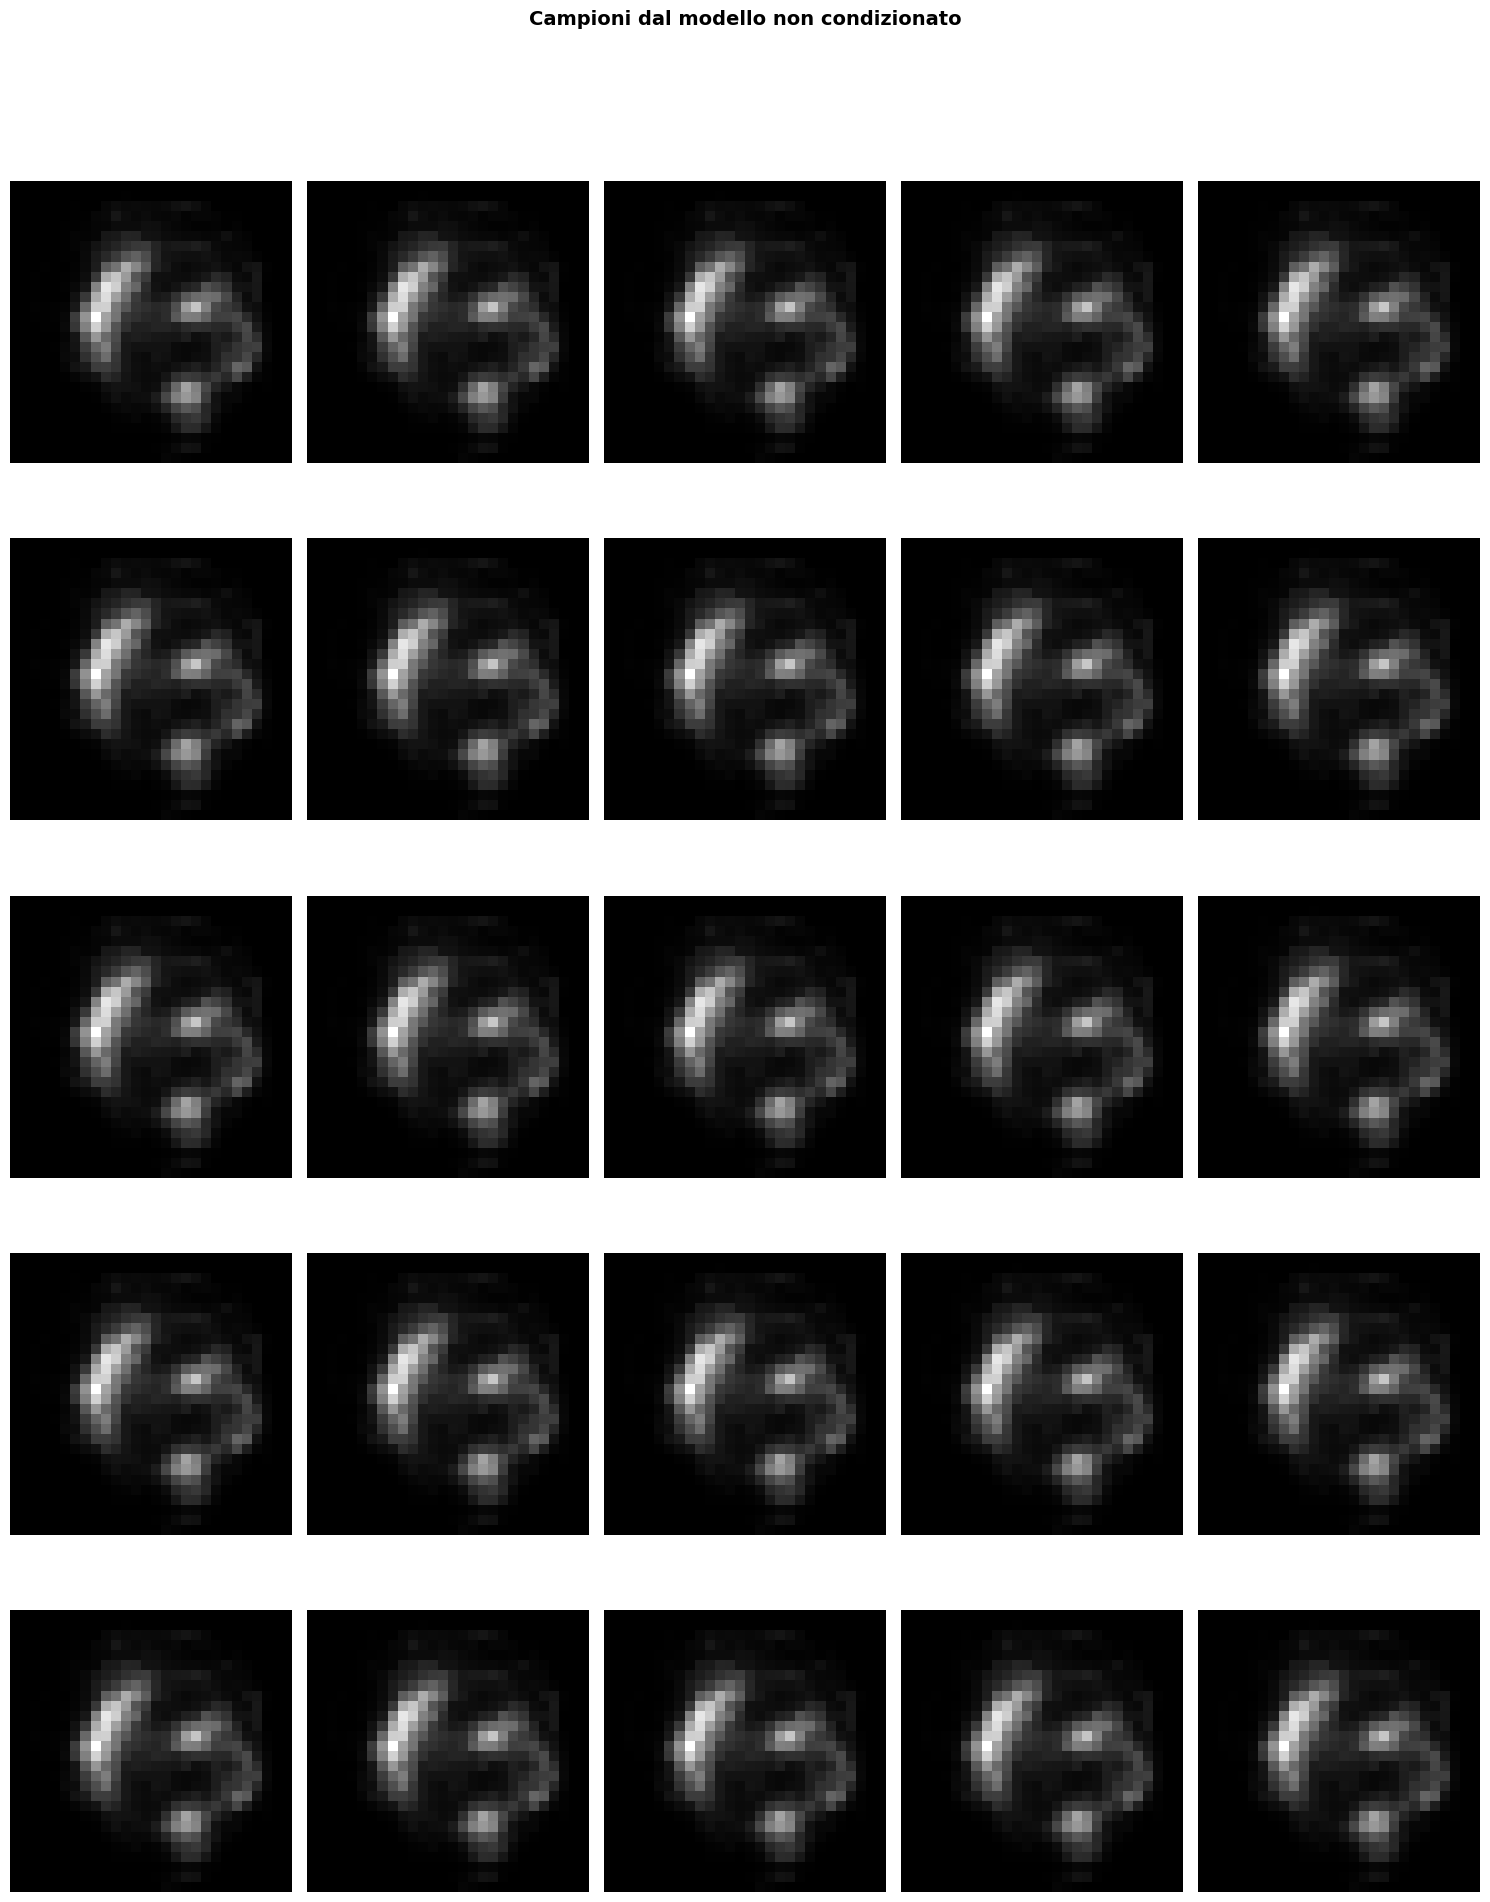

In [ ]:
print("Visualizzazione dei campioni generati:")
plot_generated_samples(samples_cond=samples_cond)